In [19]:
import pandas as pd 
import wandb
api = wandb.Api()

def get_runs_df(runs):
    summary_list, config_list, name_list, metrics_list = [], [], [], []
    for run in runs: 
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        history = run.history()
        
        # Extract specific metrics from history
        metrics = {
            "train/loss": history["train/loss"].tolist() if "train/loss" in history else None,
            "train/acc": history["train/acc"].tolist() if "train/acc" in history else None,
            "val/loss": history["val/loss"].tolist() if "val/loss" in history else None,
            "val/acc": history["val/acc"].tolist() if "val/acc" in history else None,
        }
        metrics_list.append(metrics)

        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list,
        "metrics": metrics_list
        })
    return runs_df

In [32]:
import os
import numpy as np

import matplotlib.pyplot as plt

# Функция для извлечения метрик и усреднения по рестартам
def process_metrics(runs_df, metric_key):
    metrics_data = {}
    for _, row in runs_df.iterrows():
        method_name = "_".join(row['name'].split("_")[:-2])
        if method_name not in metrics_data:
            metrics_data[method_name] = []
        metrics_data[method_name].append(row['metrics'][metric_key])
    
    # Усреднение и расчет дисперсии
    averaged_metrics = {}
    for method, values in metrics_data.items():
        values = np.array(values)
        averaged_metrics[method] = {
            'mean': np.mean(values, axis=0),
            'std': np.std(values, axis=0)
        }
    return averaged_metrics


# Функция для построения графиков
def plot_metrics(metrics, title, ylabel, save=False, save_path=None):
    plt.figure(figsize=(10, 8))  # Default size for better visibility
    markers = ['o', 's', 'D', '^', '*', 'x', 'P', 'H']  # Different markers for curves
    for idx, (method, data) in enumerate(metrics.items()):
        epochs = range(len(data['mean']))
        method_name = '_'.join(method.split('_')[:-1])
        lr = method.split('_')[-1]
        marker = markers[idx % len(markers)]  # Cycle through markers
        plt.plot(epochs, data['mean'], label=f'{method_name}, {lr=:}', linewidth=2, marker=marker, markevery=10, markersize=10)
        plt.fill_between(epochs, 
                         data['mean'] - data['std'], 
                         data['mean'] + data['std'], 
                         alpha=0.3)
    scale = 1.5
    plt.title(title, fontsize=28*scale)
    plt.xlabel("Epochs", fontsize=24*scale)
    plt.ylabel(ylabel, fontsize=24*scale)
    plt.xticks(fontsize=20*scale)
    plt.yticks(fontsize=20*scale)
    plt.legend(fontsize=20*scale, loc='best')
    plt.grid(True, linestyle='--', linewidth=1.0)
    plt.tight_layout()
    if save:
        if save_path and not os.path.exists(save_path):
            os.makedirs(save_path)
        path = f"{save_path}/{title}.pdf" if save_path else f"{title}.pdf"
        plt.savefig(path, dpi=300)
    else:
        plt.show()

# Experiment1

In [43]:
name_mapping = {
    'ImpK_b_0.001': 'ImpK_s_0.001',
    'ImpK_c_0.001': 'ImpK_c_0.001',
    'ImpK_b_EF_0.002': 'ImpK_s_EF_0.002',
    'ImpK_c_EF_0.002': 'ImpK_c_EF_0.002',
    'SCAM_b_EF_0.0001': 'ImpK_s_SCAM_0.0001',
    'SCAM_c_EF_0.0001': 'ImpK_c_SCAM_0.0001',
    'SCAM_TopK_0.0001': 'TopK_SCAM_0.0001',
}

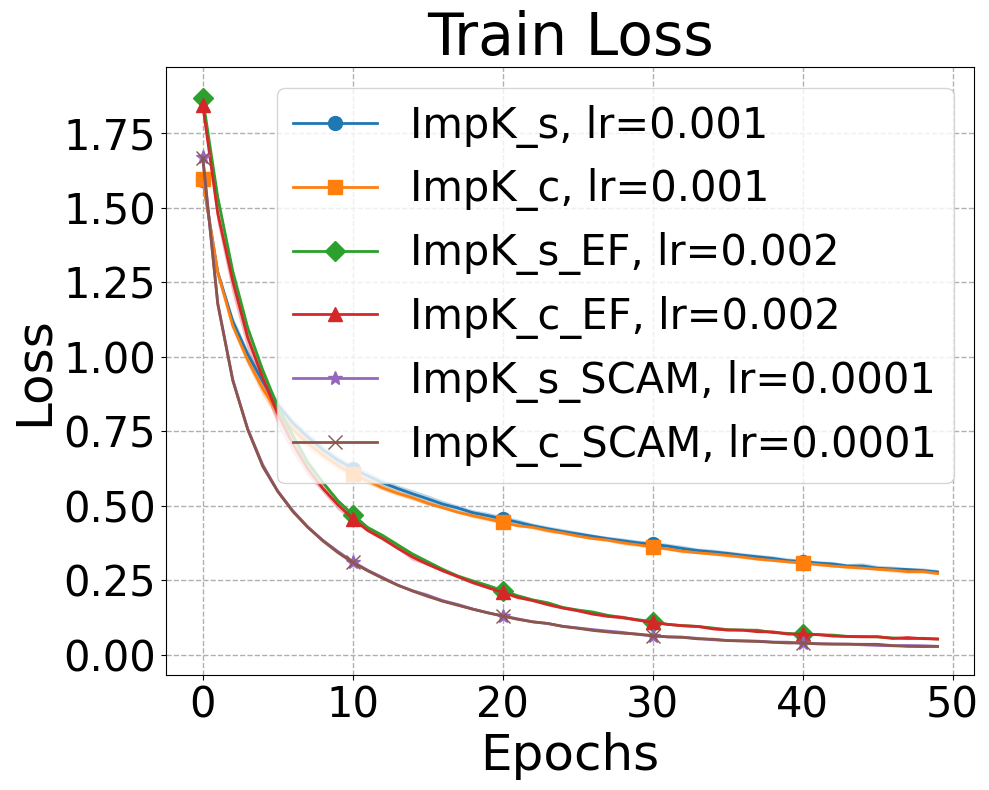

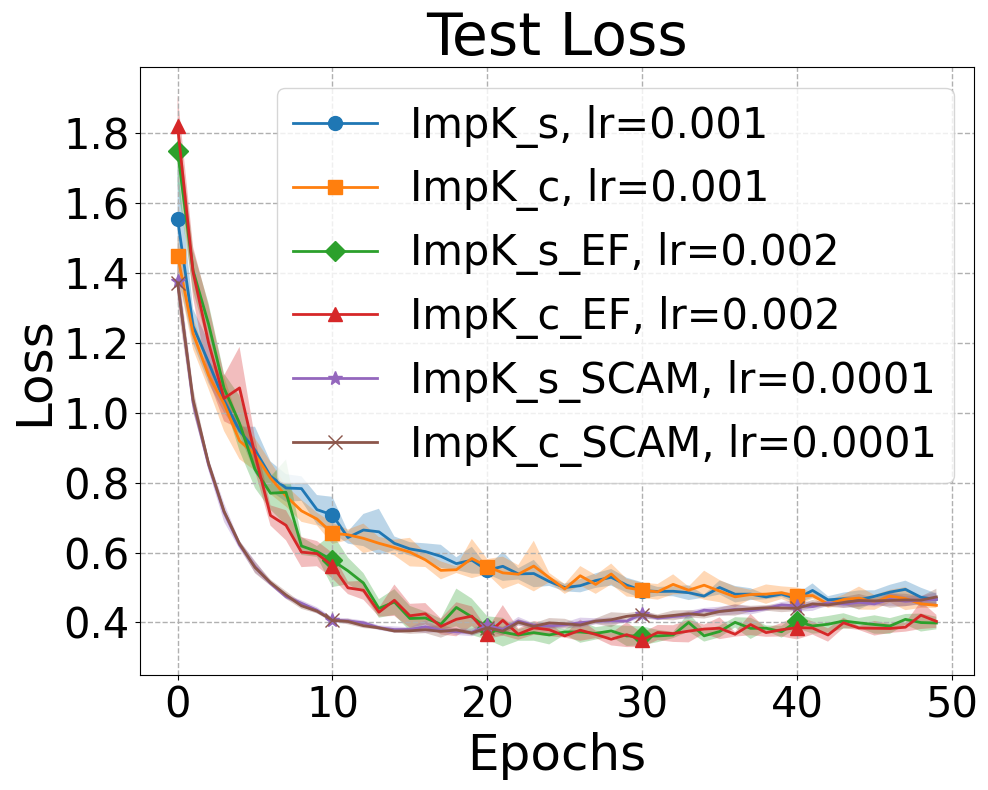

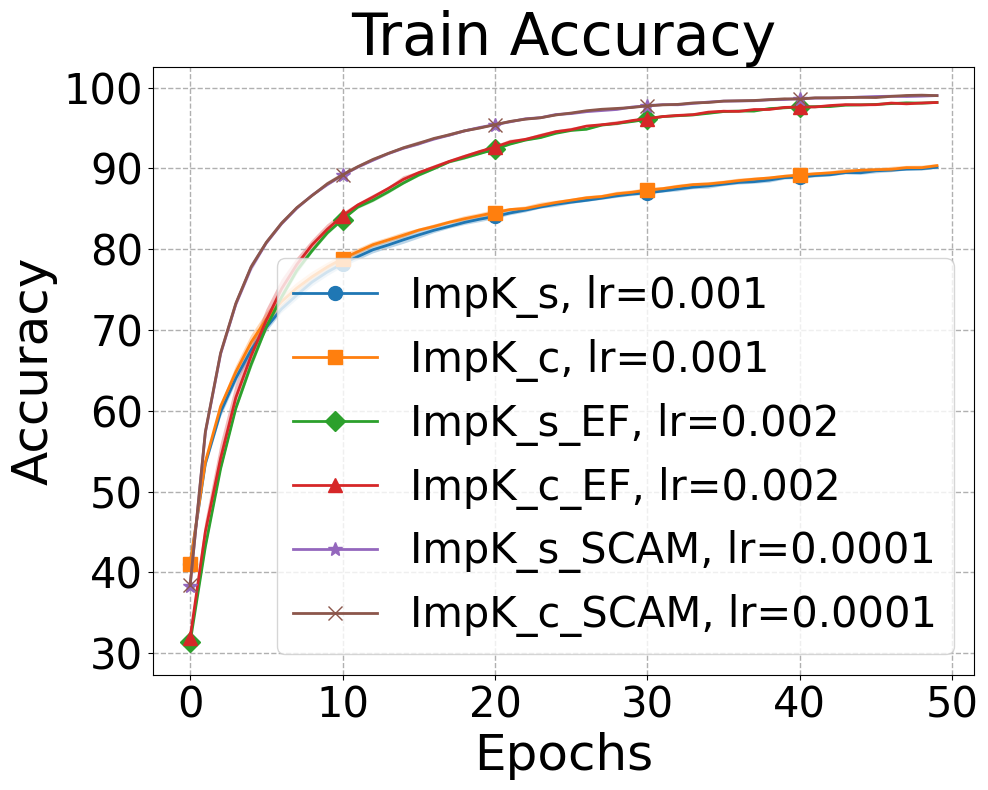

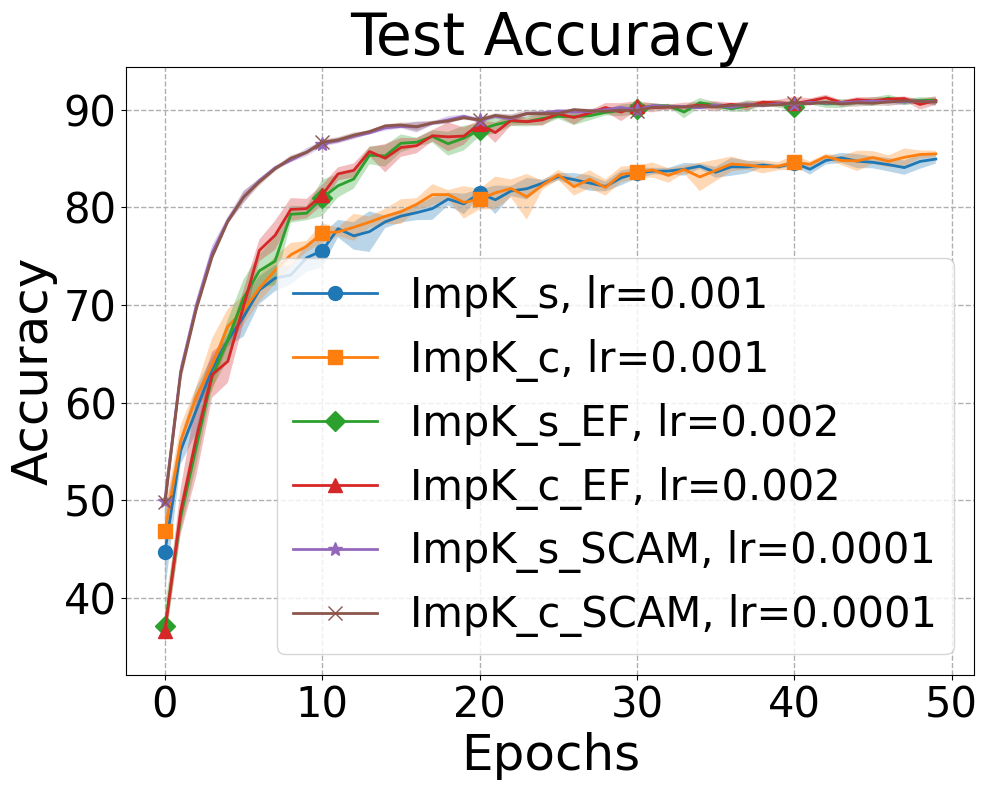

In [44]:
# Project is specified by <entity/project-name>
runs = api.runs("khafizov-research/ResNet-CIFAR-Experiment1")

runs_df = get_runs_df(runs)

# Обработка метрик
train_loss = process_metrics(runs_df, 'train/loss')
val_loss = process_metrics(runs_df, 'val/loss')
train_acc = process_metrics(runs_df, 'train/acc')
val_acc = process_metrics(runs_df, 'val/acc')

# Apply name_mapping to dict keys
train_loss = {name_mapping.get(k, k): v for k, v in train_loss.items()}
val_loss = {name_mapping.get(k, k): v for k, v in val_loss.items()}
train_acc = {name_mapping.get(k, k): v for k, v in train_acc.items()}
val_acc = {name_mapping.get(k, k): v for k, v in val_acc.items()}


# Построение графиков
plot_metrics(train_loss, "Train Loss", "Loss", save=True, save_path="experiment1")
plot_metrics(val_loss, "Test Loss", "Loss", save=True, save_path="experiment1")
plot_metrics(train_acc, "Train Accuracy", "Accuracy", save=True, save_path="experiment1")
plot_metrics(val_acc, "Test Accuracy", "Accuracy", save=True, save_path="experiment1")

# Experiment 2

In [45]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("khafizov-research/ResNet-CIFAR-Experiment2")

runs_df = get_runs_df(runs)

In [46]:
runs_df.to_csv("runs2.csv", index=False)

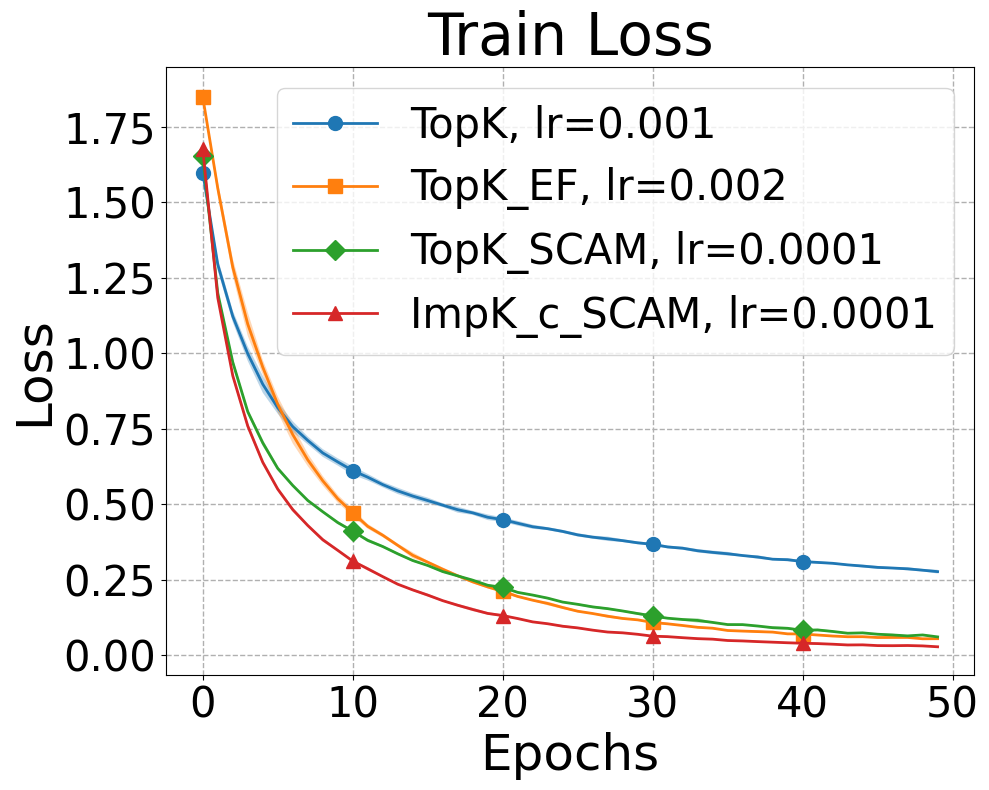

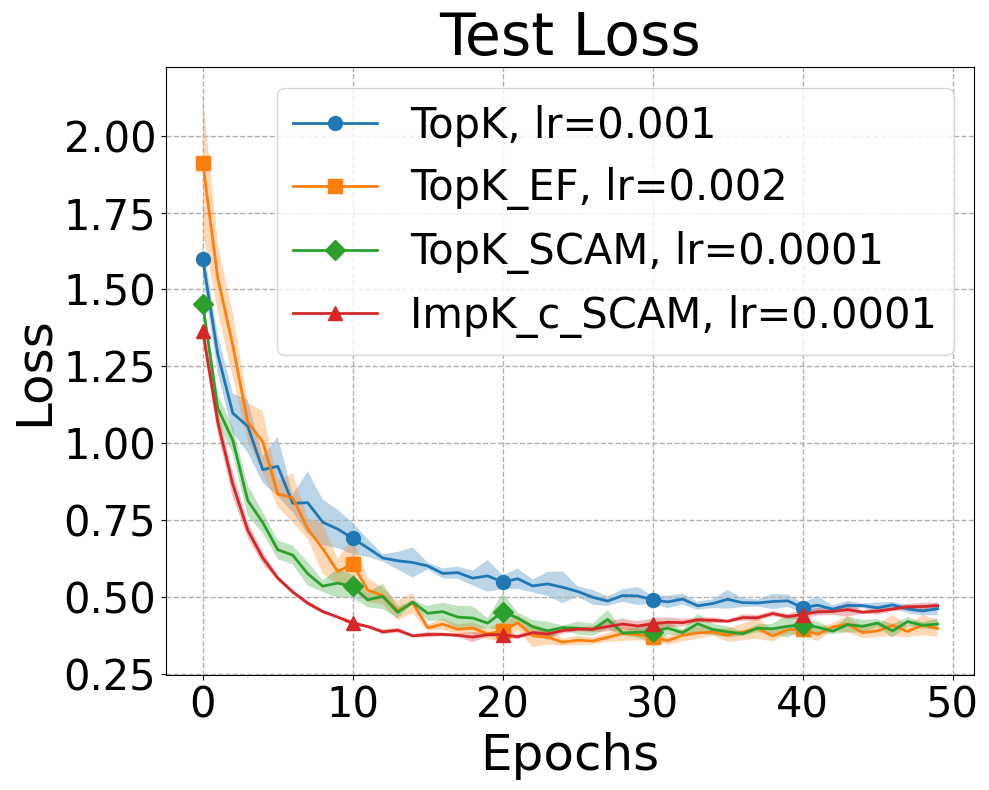

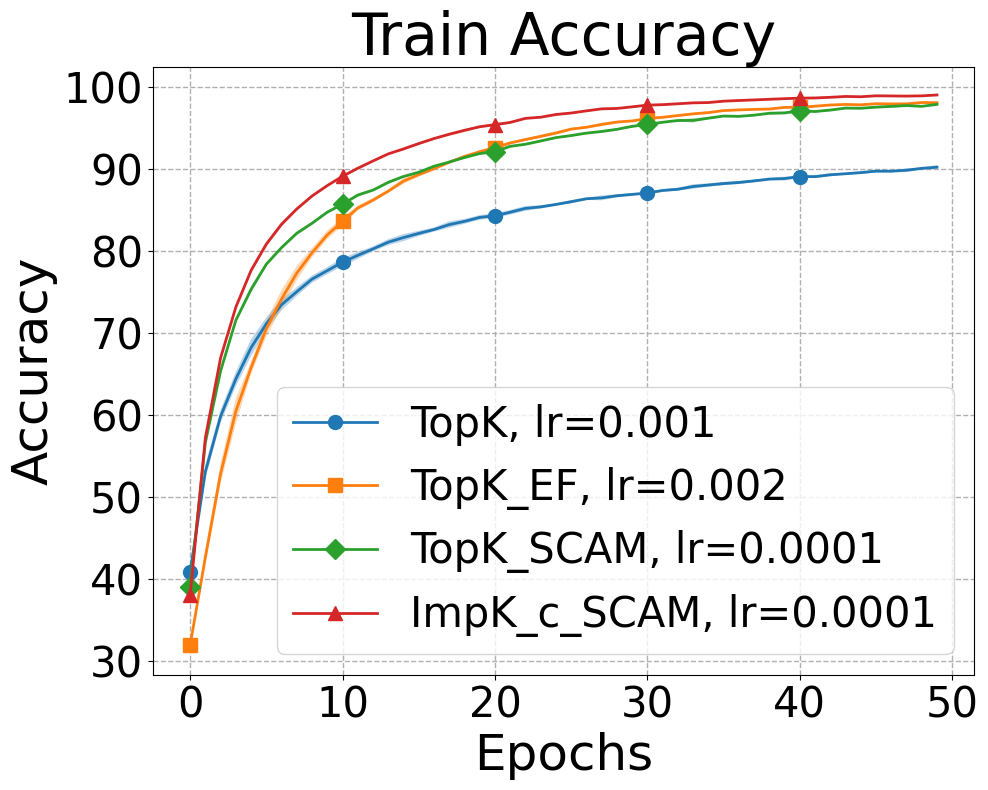

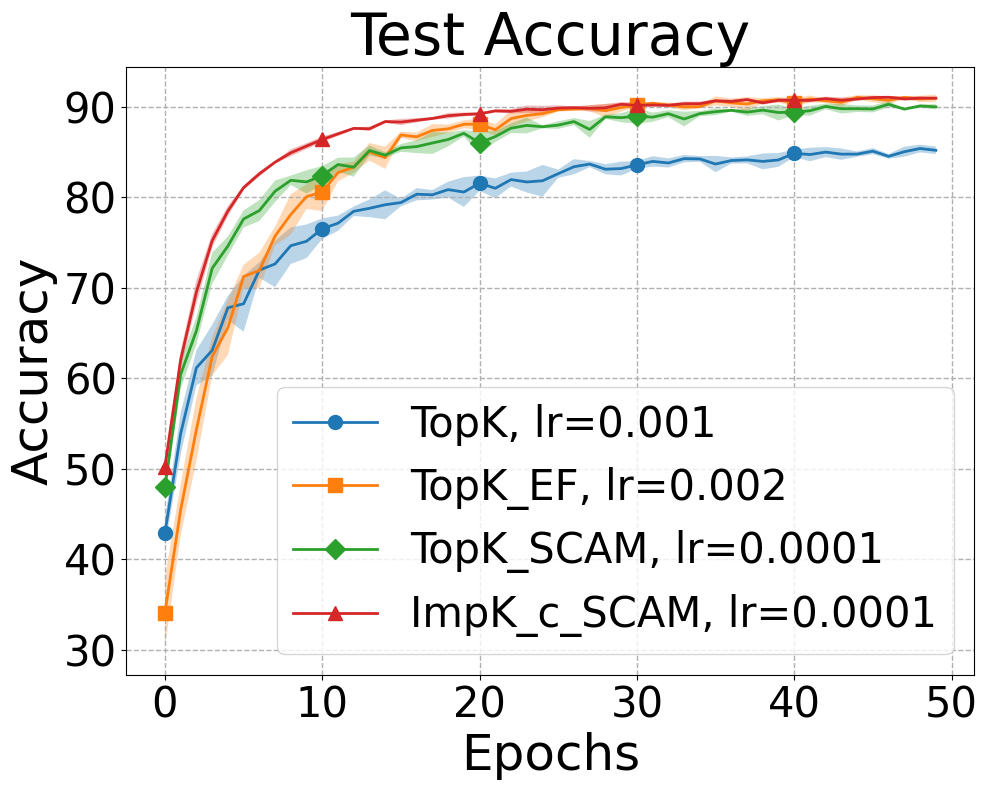

In [47]:
import os
import numpy as np

import matplotlib.pyplot as plt


# Обработка метрик
train_loss = process_metrics(runs_df, 'train/loss')
val_loss = process_metrics(runs_df, 'val/loss')
train_acc = process_metrics(runs_df, 'train/acc')
val_acc = process_metrics(runs_df, 'val/acc')

# Apply name_mapping to dict keys
train_loss = {name_mapping.get(k, k): v for k, v in train_loss.items()}
val_loss = {name_mapping.get(k, k): v for k, v in val_loss.items()}
train_acc = {name_mapping.get(k, k): v for k, v in train_acc.items()}
val_acc = {name_mapping.get(k, k): v for k, v in val_acc.items()}

save_path = "experiment2"

# Построение графиков
plot_metrics(train_loss, "Train Loss", "Loss", save=True, save_path=save_path)
plot_metrics(val_loss, "Test Loss", "Loss", save=True, save_path=save_path)
plot_metrics(train_acc, "Train Accuracy", "Accuracy", save=True, save_path=save_path)
plot_metrics(val_acc, "Test Accuracy", "Accuracy", save=True, save_path=save_path)

# Experiment 3

In [25]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("khafizov-research/ResNet-CIFAR-Experiment3")

runs_df = get_runs_df(runs)

In [26]:
runs_df.to_csv("runs3.csv", index=False)

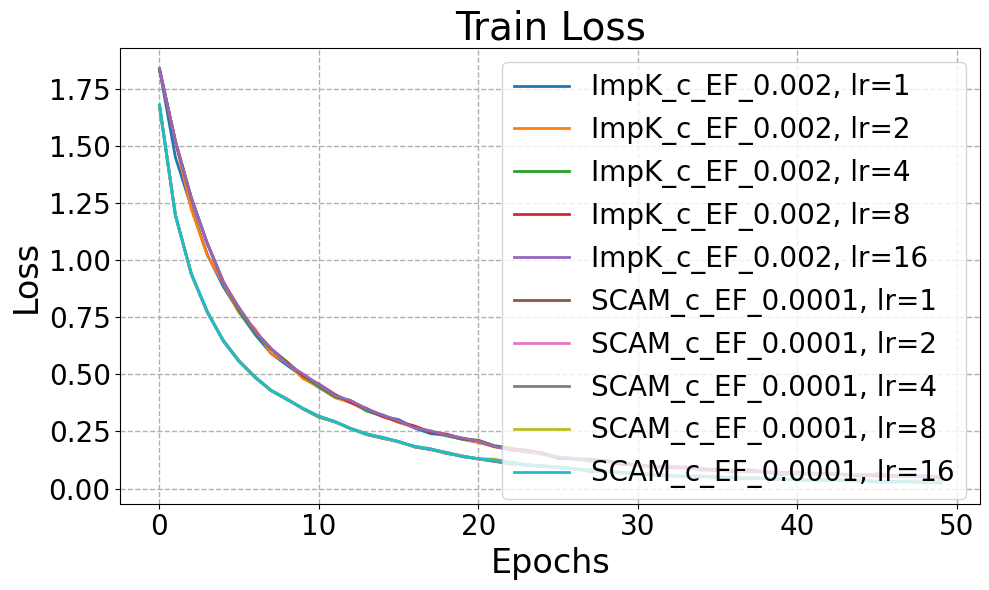

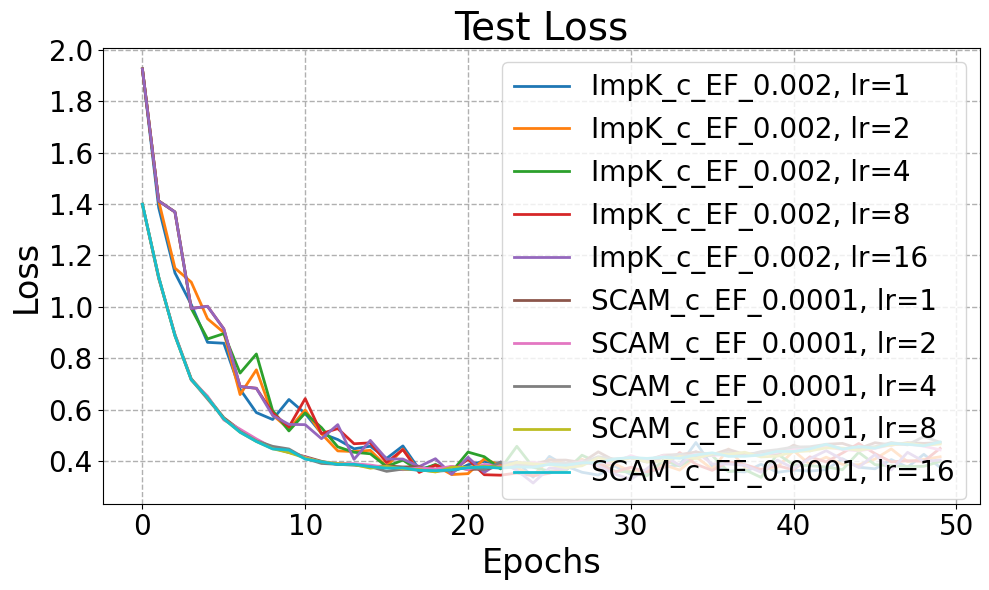

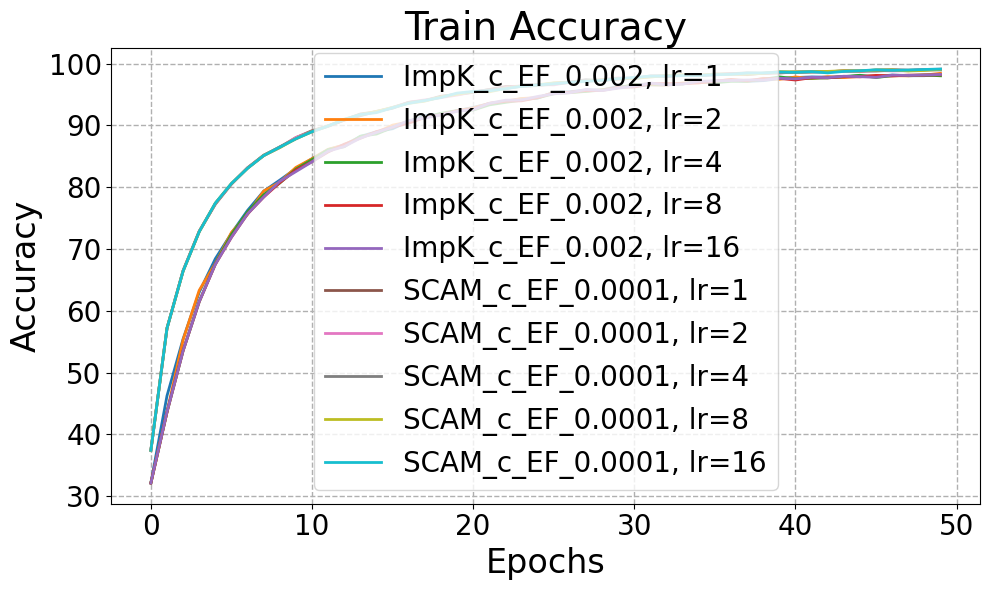

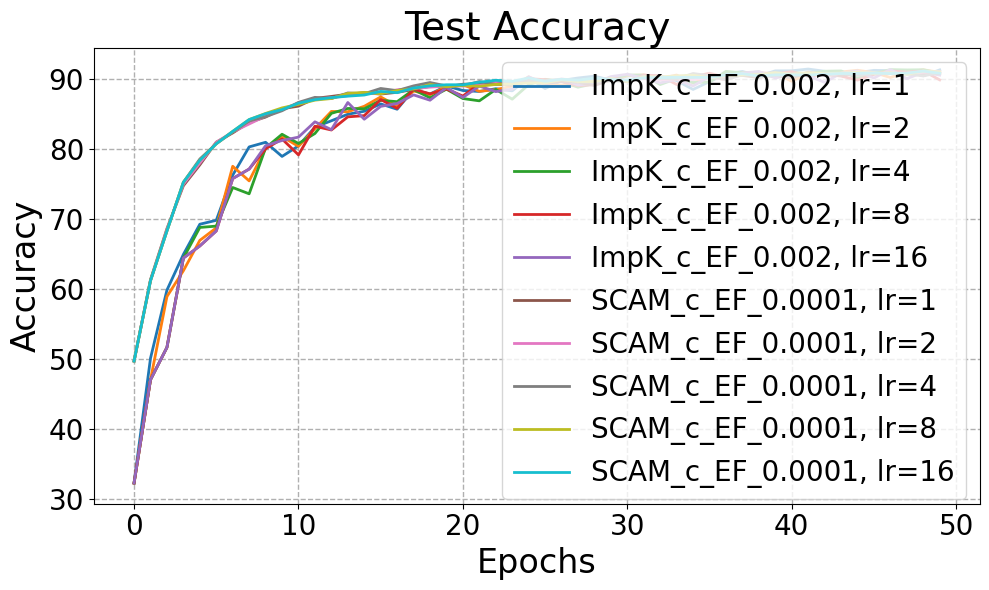

In [27]:
# Обработка метрик
train_loss = process_metrics(runs_df, 'train/loss')
val_loss = process_metrics(runs_df, 'val/loss')
train_acc = process_metrics(runs_df, 'train/acc')
val_acc = process_metrics(runs_df, 'val/acc')

save_path = "experiment3"

# Построение графиков
plot_metrics(train_loss, "Train Loss", "Loss", save=True, save_path=save_path)
plot_metrics(val_loss, "Test Loss", "Loss", save=True, save_path=save_path)
plot_metrics(train_acc, "Train Accuracy", "Accuracy", save=True, save_path=save_path)
plot_metrics(val_acc, "Test Accuracy", "Accuracy", save=True, save_path=save_path)